# **Importing Libraries**

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import joblib
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
import gensim
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

# **Loading the dataset**

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/news-category-dataset/News_Category_Dataset_v2.json


In [3]:
df = pd.read_json("../input/news-category-dataset/News_Category_Dataset_v2.json",lines=True)

# **Exploratory Data Analysis**

In [4]:
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [5]:
print(len(df.columns))

6


### The dataset contains 6 columns

In [6]:
print(len(df['category'].unique()))

41


### There are 41 news categories

In [7]:
print(df['category'].value_counts())

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, 

# **Distribution of categories**

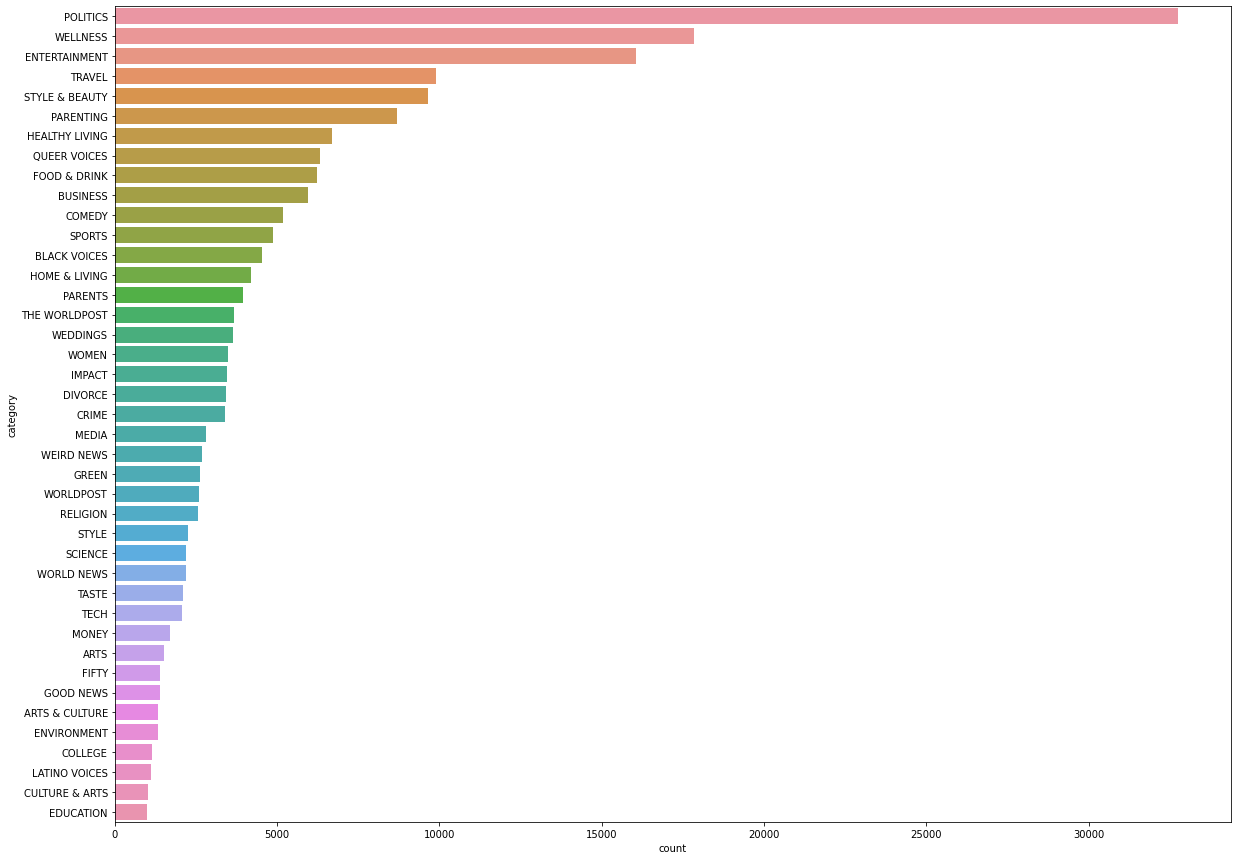

In [8]:
plt.figure(figsize=(20,15))
sns.countplot(y = 'category',data=df, order = df['category'].value_counts().index)
plt.show()


### The plot shows that majority of the news articles belong to the category Politics followed by Wellness and Entertainment. The dataset is imbalanced

# ****Data cleaning and preprocessing****

In [9]:
df_temp = df.loc[df['category'].isin(['BUSINESS', 'DIVORCE','COMEDY', 'CRIME','SPORTS', 'FOOD & DRINK'])]

In [10]:
dataset = df_temp.copy()

In [11]:
dataset.shape

(29053, 6)

In [12]:
dataset.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
32,CRIME,Rachel Dolezal Faces Felony Charges For Welfar...,Carla Herreria,https://www.huffingtonpost.com/entry/rachel-do...,"State prosecutors say almost $84,000 had been ...",2018-05-25
37,COMEDY,Trump's New 'MAGA'-Themed Swimwear Sinks On Tw...,Ed Mazza,https://www.huffingtonpost.com/entry/trump-mag...,"""Does this swimsuit make me look racist?""",2018-05-25
38,COMEDY,Seth Meyers Has 1 Funny Regret After Trump Can...,Ron Dicker,https://www.huffingtonpost.com/entry/seth-meye...,There goes the one token of his appreciation.,2018-05-25
39,COMEDY,Colbert Wants To Turn NYC Subway Rides Into A ...,Ed Mazza,https://www.huffingtonpost.com/entry/stephen-c...,"The ""Late Show"" host takes on Michael Cohen an...",2018-05-25


In [13]:
dataset['category'].value_counts()

FOOD & DRINK    6226
BUSINESS        5937
COMEDY          5175
SPORTS          4884
DIVORCE         3426
CRIME           3405
Name: category, dtype: int64

In [14]:
dataset.isnull().sum()

category             0
headline             0
authors              0
link                 0
short_description    0
date                 0
dtype: int64

No null values

In [15]:
stopwords = set(STOPWORDS)
def to_plain_text(text):
    text = re.sub('[^ ]+\.[^ ]+','',text)
    soup = BeautifulSoup(text)
    text = re.sub('[^\w\s]+',"",text, flags = re.M)
    text = re.sub('\n',"",text)
    text = re.sub('\xa0','',text)
    text = re.sub('\w_+','',text)
    text = re.sub('\w\s?[0-9]+','',text)
    text = re.sub('[0-9]','',text)
    text = text.lower()
    tokenized = nltk.word_tokenize(text)
    return tokenized

In [16]:
dataset['article'] = dataset['headline'] + " "+ dataset['short_description']

In [17]:
dataset['clean_article'] = dataset['article'].apply(to_plain_text)

In [18]:
def preprocess(docu):
    tokens = []
    lemmatizer = WordNetLemmatizer()
    stemmer = SnowballStemmer("english")
    for word in docu:
        if word not in stopwords:
            lemmatized =lemmatizer.lemmatize(word)
            stemmed =stemmer.stem(lemmatized)
            tokens.append(stemmed)
    token_words = " ".join(tokens)
    return token_words

In [19]:
dataset['clean_article'] = dataset['clean_article'].apply(preprocess)

In [20]:
X = dataset['clean_article']

In [21]:
categ = list(dataset['category'].unique())
print(categ)

['CRIME', 'COMEDY', 'SPORTS', 'BUSINESS', 'DIVORCE', 'FOOD & DRINK']


In [22]:
le = LabelEncoder()
le.fit(categ)
dataset['category'] = le.transform(dataset['category'])
y = dataset['category']

In [23]:
print(y.shape)
print(X.shape)

(29053,)
(29053,)


In [24]:
X[0]

'wer mass shoot texa last week onl tv left husband kill child anoth day america'

# **Splitting data into train and test sets**

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify = y, random_state = 5, test_size = 0.2)

In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(23242,)
(5811,)
(23242,)
(5811,)


# **Vectorizing text data using Tfidf**

In [59]:
vectorizer = TfidfVectorizer(ngram_range=(1,2),max_features = 10000)
X_train_vect = vectorizer.fit_transform(X_train)
joblib.dump(vectorizer,'vectorizer.pkl')
X_test_vect = vectorizer.transform(X_test)
print(X_train_vect.shape)
print(X_test_vect.shape)



(23242, 10000)
(5811, 10000)


## Standardizing Data

In [60]:
scaler = StandardScaler(with_mean=False)
X_train_std = scaler.fit_transform(X_train_vect)
joblib.dump(scaler,'scaler.pkl')
X_test_std = scaler.transform(X_test_vect)
X_train_std.shape, X_test_std.shape

((23242, 10000), (5811, 10000))

# **Modeling**

## Multinomial Naive Bayes

In [105]:
mnb = MultinomialNB()
parameters = {'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,10,1000,10000]}
clf = RandomizedSearchCV(mnb, parameters, cv=5,return_train_score = True)
clf.fit(X_train_std, y_train)

RandomizedSearchCV(cv=5, estimator=MultinomialNB(),
                   param_distributions={'alpha': [1e-05, 0.0005, 0.0001, 0.005,
                                                  0.001, 0.05, 0.01, 0.1, 0.5,
                                                  1, 10, 1000, 10000]},
                   return_train_score=True)

In [106]:
best_alpha= clf.best_params_['alpha']
print(best_alpha)

1000


In [109]:
nb = MultinomialNB(alpha=best_alpha)
nb.fit(X_train_std,y_train)
joblib.dump(nb,'model.pkl')
nb_preds_tr = nb.predict(X_train_std)
nb_preds_test = nb.predict(X_test_std)
probs = nb.predict_proba(X_test_std)

In [108]:
print("Train accuracy: {:.2f}".format(accuracy_score(y_train,nb_preds_tr)*100))
print("Test accuracy: {:.2f}".format(accuracy_score(y_test,nb_preds_test)*100))
auc = metrics.roc_auc_score(y_test, probs, multi_class="ovr")
print('AUC :{}'.format(auc))
print(metrics.classification_report(le.inverse_transform(y_test),le.inverse_transform(nb_preds_test)))

Train accuracy: 91.14
Test accuracy: 86.18
AUC :0.9794522537115022
              precision    recall  f1-score   support

    BUSINESS       0.81      0.88      0.85      1188
      COMEDY       0.87      0.75      0.80      1035
       CRIME       0.85      0.90      0.87       681
     DIVORCE       0.87      0.88      0.87       685
FOOD & DRINK       0.87      0.92      0.90      1245
      SPORTS       0.91      0.84      0.87       977

    accuracy                           0.86      5811
   macro avg       0.86      0.86      0.86      5811
weighted avg       0.86      0.86      0.86      5811



## Confusion matrix for train data

<AxesSubplot:>

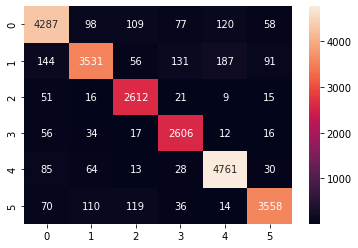

In [33]:
cm = confusion_matrix(y_train,nb_preds_tr)
sns.heatmap(cm,annot=True,fmt='d')

## Confusion matrix for test data

<AxesSubplot:>

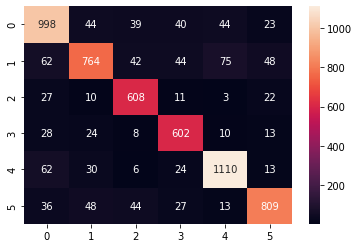

In [34]:
cm = confusion_matrix(y_test,nb_preds_test)
sns.heatmap(cm,annot=True,fmt='d')

# **Logistic Regression with cross validation**

In [35]:
lgr = LogisticRegressionCV(multi_class = 'ovr',class_weight = 'balanced',solver = 'liblinear',cv = 5,n_jobs = -1)
lgr.fit(X_train_std,y_train)
lr_preds_tr = lgr.predict(X_train_std)
lr_preds_ts = lgr.predict(X_test_std)
proba = lgr.predict_proba(X_test_std)

In [36]:
print("Train accuracy: {:.2f}".format(accuracy_score(y_train,lr_preds_tr)*100))
print("Test accuracy: {:.2f}".format(accuracy_score(y_test,lr_preds_ts)*100))
auc = metrics.roc_auc_score(y_test, proba, multi_class="ovr")
print('AUC :{}'.format(auc))
print(metrics.classification_report(le.inverse_transform(y_test),le.inverse_transform(lr_preds_ts)))

Train accuracy: 98.68
Test accuracy: 86.56
AUC :0.9800216037275997
              precision    recall  f1-score   support

    BUSINESS       0.85      0.85      0.85      1188
      COMEDY       0.83      0.77      0.80      1035
       CRIME       0.84      0.90      0.87       681
     DIVORCE       0.86      0.91      0.88       685
FOOD & DRINK       0.91      0.92      0.92      1245
      SPORTS       0.88      0.86      0.87       977

    accuracy                           0.87      5811
   macro avg       0.86      0.87      0.86      5811
weighted avg       0.87      0.87      0.87      5811



## Confusion matrix for train data 

<AxesSubplot:>

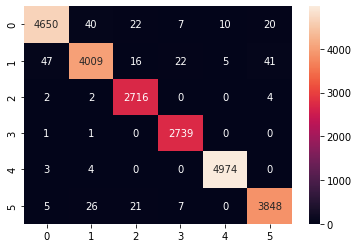

In [37]:
cm = confusion_matrix(y_train,lr_preds_tr)
sns.heatmap(cm,annot=True,fmt='d')

## Confusion matrix for test data

<AxesSubplot:>

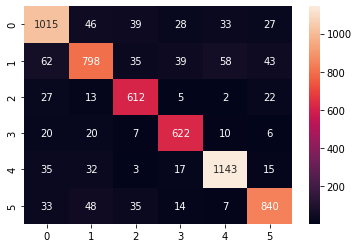

In [38]:
cm = confusion_matrix(y_test,lr_preds_ts)
sns.heatmap(cm,annot=True,fmt='d')

# **Advanced Modeling**

## Stacking Classifier

In [39]:
from sklearn.ensemble import StackingClassifier

In [40]:
estimators = [
    ('dt', DecisionTreeClassifier()),
    ('mnb', MultinomialNB(alpha = 100))
]

In [41]:
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegressionCV(multi_class = 'ovr',class_weight = 'balanced',solver = 'liblinear',cv = 5,n_jobs = -1))

In [42]:
clf.fit(X_train_std,y_train)

StackingClassifier(estimators=[('dt', DecisionTreeClassifier()),
                               ('mnb', MultinomialNB(alpha=100))],
                   final_estimator=LogisticRegressionCV(class_weight='balanced',
                                                        cv=5, multi_class='ovr',
                                                        n_jobs=-1,
                                                        solver='liblinear'))

In [111]:
st_preds = clf.predict(X_test_std)

In [43]:
clf.score(X_test_std,y_test)

0.8444329719497504

<AxesSubplot:>

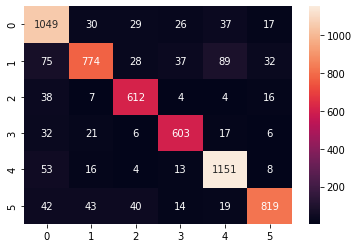

In [112]:
cm = confusion_matrix(y_test,st_preds)
sns.heatmap(cm,annot=True,fmt='d')

## Bidirectional LSTM

In [44]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot

In [45]:
onehot_rep=[one_hot(words,5000)for words in X]

In [47]:
max_length=20
embedding=pad_sequences(onehot_rep,padding='post',maxlen=max_length)
print(embedding)

[[4599  758 3485 ...    0    0    0]
 [4968  628 4158 ...    0    0    0]
 [3547 4642 4710 ...    0    0    0]
 ...
 [2403 2927 4388 ... 3506 3289 1859]
 [ 265 1425 1796 ...  833    0    0]
 [4519 2876 4932 ... 4252 4446 1448]]


In [49]:
model=Sequential()
model.add(Embedding(5000,100,input_length=max_length))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(6,activation='softmax'))
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),optimizer='adam',metrics=['accuracy'])
earlystop = EarlyStopping(monitor='val_loss',min_delta=0,patience=2,restore_best_weights=True)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 100)           500000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               160800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1206      
Total params: 662,006
Trainable params: 662,006
Non-trainable params: 0
_________________________________________________________________
None


In [50]:
X_last = embedding

In [52]:
X_tr2,X_te2,y_tr2,y_te2 = train_test_split(X_last,y,stratify = y, test_size = 0.2)
X_tr,X_val,y_tr,y_val = train_test_split(X_tr2,y_tr2,stratify = y_tr2,test_size = 0.2)

In [54]:
model.fit(X_tr,y_tr,validation_data=(X_val,y_val),epochs = 20,callbacks = earlystop)

Epoch 1/20
582/582 [==============================] - 23s 39ms/step - loss: 0.7261 - accuracy: 0.7447 - val_loss: 0.5280 - val_accuracy: 0.8193
Epoch 2/20
582/582 [==============================] - 22s 39ms/step - loss: 0.3803 - accuracy: 0.8739 - val_loss: 0.5422 - val_accuracy: 0.8133
Epoch 3/20
582/582 [==============================] - 22s 38ms/step - loss: 0.2658 - accuracy: 0.9158 - val_loss: 0.6045 - val_accuracy: 0.8058


In [56]:
y_pred=model.predict(X_te2)

In [57]:
y_class = y_pred.argmax(axis=-1)

In [58]:
accuracy_score(y_te2,y_class)

0.825503355704698

<AxesSubplot:>

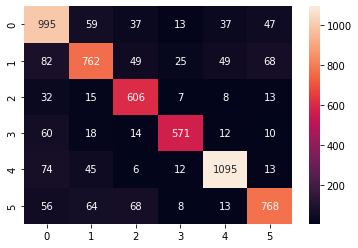

In [110]:
cm = confusion_matrix(y_te2,y_class)
sns.heatmap(cm,annot=True,fmt='d')

## 